In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Graph_Neural_Network')

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import TAGConv, GCNConv, SAGEConv, GATConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

In [5]:
# ========== Step 1: 数据加载与预处理 ==========
df_classes = pd.read_csv('./data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv')
df_features = pd.read_csv('./data/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)
df_edges = pd.read_csv('./data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')

In [6]:
# 删除 unknown 类别，仅保留合法/非法交易（1/2），合并特征与类别标签
df_classes = df_classes[df_classes['class'] != 'unknown']
df_classes['class'] = df_classes['class'].astype(str).map({'1': 1, '2': 0})  # 1: illicit, 0: licit
df_merge = df_features.merge(df_classes, how='inner', right_on='txId', left_on=0).drop(columns=['txId'])

/tmp/ipython-input-6-1178721068.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_classes['class'] = df_classes['class'].astype(str).map({'1': 1, '2': 0})  # 1: illicit, 0: licit


In [7]:
# ====================== 图构建 ======================
nodes = df_merge[0].values
map_id = {j: i for i, j in enumerate(nodes)}
edges = df_edges[df_edges.txId1.isin(map_id) & df_edges.txId2.isin(map_id)].copy()
edges.txId1 = edges.txId1.map(map_id)
edges.txId2 = edges.txId2.map(map_id)
edge_index = torch.tensor(edges.values.T, dtype=torch.long)

In [8]:
# 特征与标签
x = torch.tensor(df_merge.drop([0, 'class', 1], axis=1).values, dtype=torch.float32)
y = torch.tensor(df_merge['class'].values, dtype=torch.float32)
data = Data(x=x, edge_index=edge_index, y=y)

In [9]:
# 划分训练/验证/测试集
all_idx = np.arange(len(y))
train_idx, temp_idx = train_test_split(all_idx, test_size=0.3, stratify=y, random_state=0)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=y[temp_idx], random_state=0)

train_idx = torch.tensor(train_idx)
val_idx = torch.tensor(val_idx)
test_idx = torch.tensor(test_idx)

In [10]:
# ========== Step 2: 定义模型结构 ==========
class TGNN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, K=3):
        super().__init__()
        self.norm1 = torch.nn.BatchNorm1d(dim_in)
        self.conv1 = TAGConv(dim_in, dim_h, K)
        self.norm2 = torch.nn.BatchNorm1d(dim_h)
        self.conv2 = TAGConv(dim_h, dim_out, K)

    def forward(self, x, edge_index):
        x = self.norm1(x)
        x = self.conv1(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = self.conv2(x, edge_index)
        return x

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=2)
        self.conv2 = GATConv(hidden_channels * 2, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return x

In [11]:
# ========== Step 3: GNN训练函数 ==========
def train_gnn(model, data, train_idx, val_idx, optimizer, criterion, epochs=200):
    model.train()
    for _ in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[train_idx], data.y[train_idx].unsqueeze(1))
        loss.backward()
        optimizer.step()
    return model

def get_gnn_pr_curve(model, data, test_idx):
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)[test_idx].squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
    labels = data.y[test_idx].cpu().numpy()
    precision, recall, _ = precision_recall_curve(labels, probs)
    ap = average_precision_score(labels, probs)
    return precision, recall, ap

# ========== Step 4: ML训练与PR提取 ==========
def train_ml_models(X_train, X_test, y_train, y_test):
    models = {
        'LR': LogisticRegression(max_iter=1000),
        'SVM': SVC(probability=True),
        'KNN': KNeighborsClassifier(n_neighbors=5)
    }
    pr_curves = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_probs = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_probs)
        ap = average_precision_score(y_test, y_probs)
        pr_curves[name] = (precision, recall, ap)
    return pr_curves


In [14]:
# ========== Step 5: 所有模型训练并提取 PR ==========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

gnn_models = {
    'Proposed model': TGNN(x.shape[1], 100, 1),
    'GCN': GCN(x.shape[1], 100, 1),
    'GraphSAGE': GraphSAGE(x.shape[1], 100, 1),
    'GAT': GAT(x.shape[1], 64, 1),
}

pr_curves = {}

for name, model in gnn_models.items():
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)
    criterion = torch.nn.BCEWithLogitsLoss()
    print(f"Training {name}...")
    train_gnn(model, data, train_idx, val_idx, optimizer, criterion)
    pr_curves[name] = get_gnn_pr_curve(model, data, test_idx)

# 为 ML 模型准备 numpy 格式的数据
X = x.cpu().numpy()
y_np = y.cpu().numpy()
X_train, X_temp, y_train, y_temp = train_test_split(X, y_np, test_size=0.3, stratify=y_np, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=0)

ml_pr_curves = train_ml_models(X_train, X_test, y_train, y_test)
pr_curves.update(ml_pr_curves)

Training Proposed model...
Training GCN...
Training GraphSAGE...
Training GAT...


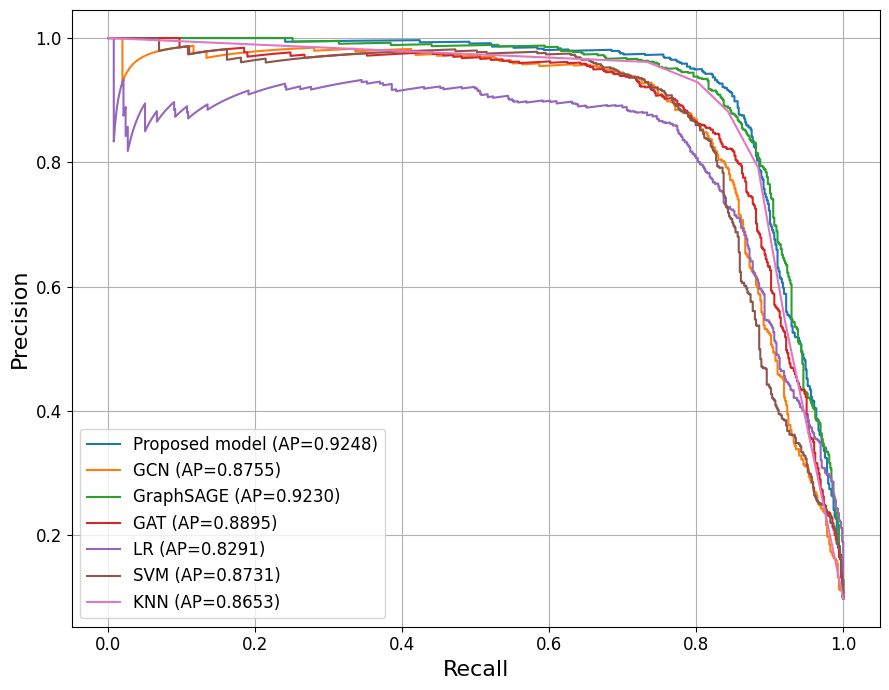

In [23]:
# ========== Step 6: 绘图 ==========
plt.figure(figsize=(9, 7))

for name, (precision, recall, ap) in pr_curves.items():
  plt.plot(recall, precision, label=f'{name} (AP={ap:.4f})')

plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
# plt.title("Precision-Recall Curve of GNN and ML Models")
plt.legend(fontsize=12)
plt.tick_params(axis='both', labelsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("./result/pr_curves_all_models.png", dpi=300)
plt.show()